<a href="https://colab.research.google.com/github/Ahmad08017928/Ahmad08017928/blob/main/Submision_akhir_dicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Library**

In [1]:
# Library yang sering digunakan
import os, shutil, json
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, Add, Activation, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout, Input, Add, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#**Mengkoneksi-kan ke Kaggle**

In [5]:
# Menyimpan API token di ~/.kaggle/kaggle.json
os.makedirs('/root/.kaggle/', exist_ok=True)

api_token = {"username": "what6476", "key": "6eda561fb1794c48b6140e3ade630090"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Atur izin
os.chmod('/root/.kaggle/kaggle.json', 600)

#**Install Kaggle dan Unzip file yang di tuju**

In [6]:
!pip install -q kaggle

In [7]:
# Download dan unzip dataset
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images
!unzip labeled-chest-xray-images.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-26

In [8]:
# Direktori awal untuk train dan test
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

# Direktori baru untuk dataset gabungan
combined_dir = "chest_xray/dataset"

In [9]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [10]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

#**Data Checking**

In [11]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "chest_xray/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

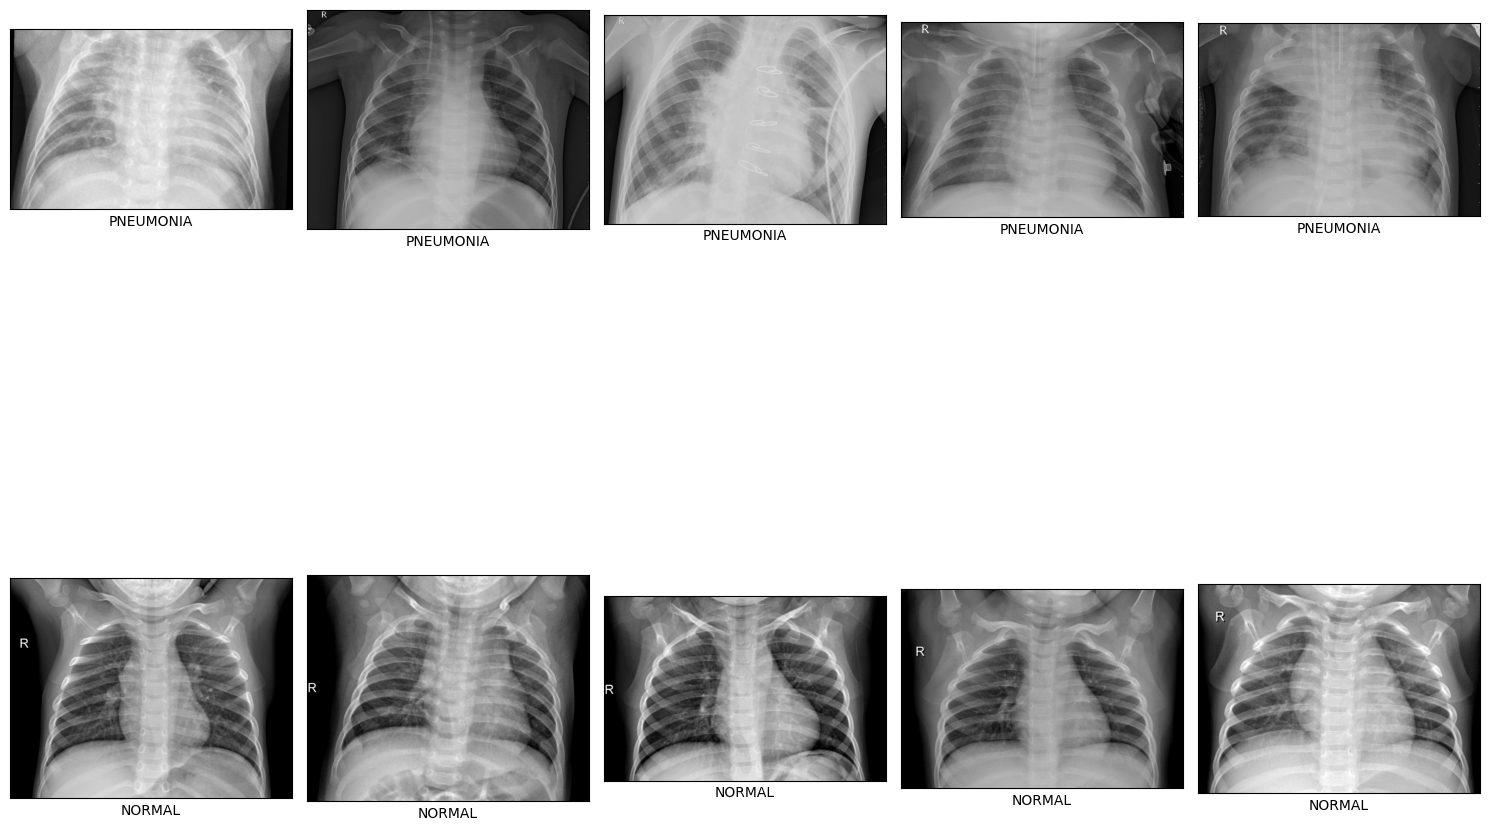

In [12]:
# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "chest_xray/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

In [13]:
# Definisikan path sumber
lung_path = "chest_xray/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

#**Data Augmentation**

In [14]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [15]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="chest_xray/dataset/NORMAL" # Path untuk gambar asli
augmented_path="chest_xray/dataset/NORMAL" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=2000
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

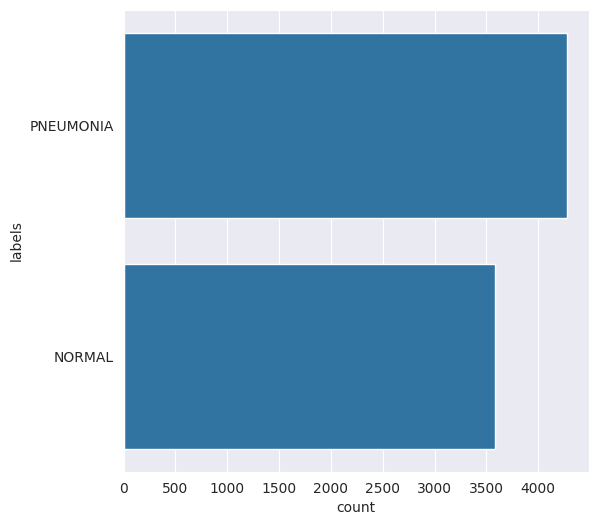

In [16]:
# Definisikan path sumber
lung_path = "chest_xray/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#**Data Splitting**

In [17]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'chest_xray/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
NORMAL,3583
PNEUMONIA,4273


In [18]:
from sklearn.model_selection import train_test_split

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [19]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [20]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "chest_xray/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels   
test   NORMAL        733
       PNEUMONIA     839
train  NORMAL       2850
       PNEUMONIA    3434
dtype: int64 


                                                   path     labels    set
7512  chest_xray/dataset/PNEUMONIA/BACTERIA-6340005-...  PNEUMONIA   test
940   chest_xray/dataset/NORMAL/NORMAL-2550782-0001....     NORMAL  train
7618  chest_xray/dataset/PNEUMONIA/BACTERIA-9364007-...  PNEUMONIA   test
876   chest_xray/dataset/NORMAL/NORMAL-3902817-0001....     NORMAL  train
1700  chest_xray/dataset/NORMAL/augmented_image_592.jpg     NORMAL  train


In [21]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

#**Image Data Generator**

In [22]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_normal = os.path.join(TRAIN_DIR + '/NORMAL')
train_pneumonia = os.path.join(TRAIN_DIR + '/PNEUMONIA')
test_normal = os.path.join(TEST_DIR + '/NORMAL')
test_pneumonia = os.path.join(TEST_DIR + '/PNEUMONIA')

print("Total number of normal images in training set: ",len(os.listdir(train_normal)))
print("Total number of pneumonic images in training set: ",len(os.listdir(train_pneumonia)))
print("Total number of normal images in test set: ",len(os.listdir(test_normal)))
print("Total number of pneumonic images in test set: ",len(os.listdir(test_pneumonia)))

Total number of normal images in training set:  2850
Total number of pneumonic images in training set:  3434
Total number of normal images in test set:  733
Total number of pneumonic images in test set:  839


In [23]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 5028 images belonging to 2 classes.
Found 1256 images belonging to 2 classes.
Found 1572 images belonging to 2 classes.


#**Model ResNet**

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

# Clear session
tf.keras.backend.clear_session()

# Build Sequential model
model_organ = Sequential([
    # Input layer
    Conv2D(32, (3, 3), padding='same', input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Second block
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third block
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Fourth block
    Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),

    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model_organ.compile(optimizer=tf.keras.optimizers.RMSprop(),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Summary of the Model Architecture
print(model_organ.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,2

 Total params: 430,977 (1.64 MB)

 Trainable params: 430,017 (1.64 MB)

 Non-trainable params: 960 (3.75 KB)

None


In [28]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85):
          print("\nAkurasi telah mencapai >85%")
          self.model.stop_training = True

callbacks = myCallback()

# Fitting / training model
history_1 = model_organ.fit(train_generator,
                        epochs=3,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights,
                        # callbacks=callbacks
                        )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


158/158 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.7820 - loss: 0.7288 - val_accuracy: 0.5462 - val_loss: 4.2945
Epoch 2/3
158/158 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.9104 - loss: 0.3744 - val_accuracy: 0.5462 - val_loss: 4.9450
Epoch 3/3
158/158 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - accuracy: 0.9184 - loss: 0.3159 - val_accuracy: 0.7986 - val_loss: 0.7531


# **Grafik akurasi dan loss**

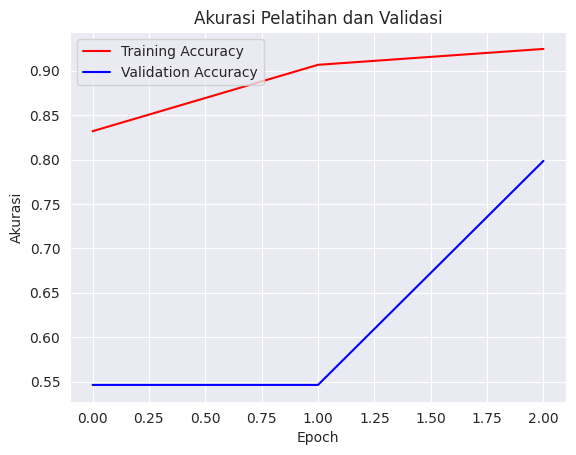

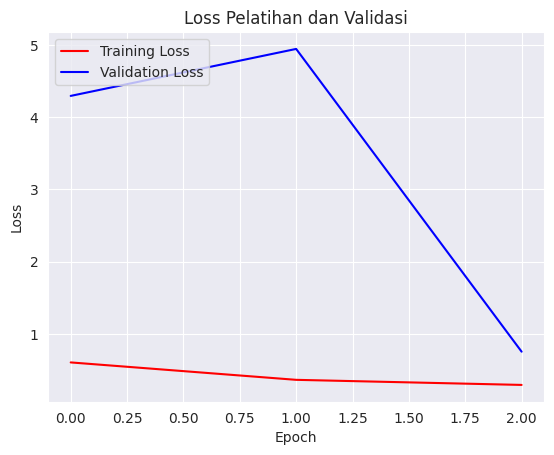

In [29]:
# Mengambil data akurasi dan loss dari history pelatihan
train_acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epoch_range = range(len(train_acc))

# Plot Akurasi Pelatihan dan Validasi
plt.plot(epoch_range, train_acc, color='red', label='Training Accuracy')
plt.plot(epoch_range, val_acc, color='blue', label='Validation Accuracy')
plt.title('Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='upper left')
plt.show()

# Plot Loss Pelatihan dan Validasi
plt.plot(epoch_range, train_loss, color='red', label='Training Loss')
plt.plot(epoch_range, val_loss, color='blue', label='Validation Loss')
plt.title('Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

#**Akurasi ML**

In [30]:
# Mengatur ulang test generator
test_generator.reset()

# Melakukan prediksi pada test set
predictions = model_organ.predict(test_generator, verbose=0)
predictions = predictions.copy()

# Mengonversi probabilitas menjadi label biner berdasarkan threshold 0.5
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

# Menampilkan laporan klasifikasi
from sklearn.metrics import classification_report
print("\nLaporan Klasifikasi:")
print(classification_report(y_true=test_generator.classes, y_pred=predictions, target_names=['Normal', 'Pneumonia'], digits=4))



Laporan Klasifikasi:
              precision    recall  f1-score   support

      Normal     0.9561    0.6535    0.7763       733
   Pneumonia     0.7628    0.9738    0.8555       839

    accuracy                         0.8244      1572
   macro avg     0.8595    0.8136    0.8159      1572
weighted avg     0.8529    0.8244    0.8186      1572



#**Save Model**

In [31]:
# Mendapatkan class names dari train generator
class_indices = train_generator.class_indices

# Mengubah dictionary class_indices menjadi list class names
class_names = list(class_indices.keys())
print(class_names)

['NORMAL', 'PNEUMONIA']


In [32]:
# Simpan model ke format SavedModel
tf.saved_model.save(model_organ, "saved_model")

#**Mengonversi Model ke TensorFlow Lite**

In [33]:
model_organ.save('model_saya.keras')

In [34]:
# Muat model yang telah disimpan dalam format .keras
model = tf.keras.models.load_model('model_saya.keras')


os.makedirs('tflite', exist_ok=True)

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp8z02ez1r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139076370712528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139076370723264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139076370192992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139076370194576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139076370190528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139076370195456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139076369212944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139076369217872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139076369211184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139076369206608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139076369204320

In [35]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 56.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [36]:
# Konversi SavedModel ke format TFJS
import os
os.makedirs('tfjs_model', exist_ok=True)

In [37]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model/

2024-09-22 14:47:39.211453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 14:47:39.250153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 14:47:39.258124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 14:47:41.308782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1727016469.914759    9018 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
